# Full Statistical Equilibrium

- 2020.06.26 : Kouui  

- 2020.07.07 : Kouui : added equation and description

- 2020.07.16 : Kouui : 
    - re-constructed `Atom()` class
    - `Class.help`

TODO :

- function | show all attributes in a class

- plot | Te, Ne v.s. collisional ionization/excitation

- plot | photoionization v.s. collisional ionization

- plot | photo-excitation v.s. collisional excitation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

from src.Structure import AtomCls, AtmosphereCls
from src.Atomic import Collision, PhotoIonize
from src.Atomic import LTELib, SEsolver, BasicP
from src.RadiativeTransfer import Profile
from src.Math import Integrate
from src import Constants as Cst

from src.Visual import Grotrian

from src.Util import Class

In [1]:
from scipy.interpolate import interp1d

---

- `.read_CI` :

    read collisional ionization data


- `.read_PI` : 

    read photoionization data
    

- `.read_RadiativeLine_and_make_Line_Mesh` :

    read parameter for radiative line wavelength mesh construction, and then create wavelength mesh for radiative line transitions
    
    
- `.make_Cont_Mesh` : 

    create wavelength mesh for continuum transitions
    
    
- `.read_RadLine_intensity` : 

    read line profiles of incident radiation for specific line transition

In [24]:
folder = "../data/atom/Ca_II/"
file_Level     = folder + "Ca_II.Level"
file_Aji = folder + "Einstein_A/Nist.Aji"
file_CEe = folder + "Collisional_Excitation/RH.Electron"
atom = AtomCls.Atom(file_Level, _file_Aji=file_Aji, _file_CEe=file_CEe)

file_CIe = folder + "Collisional_Ionization/RH.Electron"
atom.read_CI(_path_electron=file_CIe)

file_PI  = folder + "Photoionization/RH.Alpha"
atom.read_PI(_path_alpha=file_PI)

file_Rad = folder + "Ca_II.RadiativeLine"
atom.read_RadiativeLine_and_make_Line_Mesh(_path=file_Rad)
atom.make_Cont_Mesh()
atom.read_RadLine_intensity(_folder="../data/intensity/Ca_II/")

Reading Einstein Aji coefficient from : 
 ../data/atom/Ca_II/Einstein_A/Nist.Aji
...
Finished.

Reading Electron impact Effective Collisional Strength from : 
 ../data/atom/Ca_II/Collisional_Excitation/RH.Electron
Finished.

Reading Electron impact Collisional Ionization coefficient from : 
 ../data/atom/Ca_II/Collisional_Ionization/RH.Electron
Finished.

Reading Photoionization cross section from : 
 ../data/atom/Ca_II/Photoionization/RH.Alpha
Finished.

Reading Radiative Line information from : 
 ../data/atom/Ca_II/Ca_II.RadiativeLine
line mesh prepared.
continuum mesh prepared.


In [25]:
Class.help(atom)

Attributes
----------------------------------------------------------------------
name                         type               value/len/shape
----------------------------------------------------------------------

filepath_dict                dict               l: 6
Title                        str                v: Ca II H/K ...
Z                            int                v: 20
Element                      str                v: Ca
nLevel                       int                v: 6
Mass                         float              v: 40.08
Abun                         float              v: 2.5118864315095823e-06
Level                        recarray           ---
  |-> erg                    float64 array      s: (6,)
  |-> g                      uint8 array        s: (6,)
  |-> stage                  uint8 array        s: (6,)
  |-> gamma                  float64 array      s: (6,)
  |-> isGround               bool array         s: (6,)
Level_ctj_table              tuple      

- `Grotrian.Grotrian` : 

    create `Grotrian` object base on the Level information of the `atom` object
    
    
- `.make_fig` : 

    create grotrian diagram figure
    
    
- `.connect_line` : 

    connect `transitions` between levels and levels
    
    
- `.show_fig` : 

    show the created figure

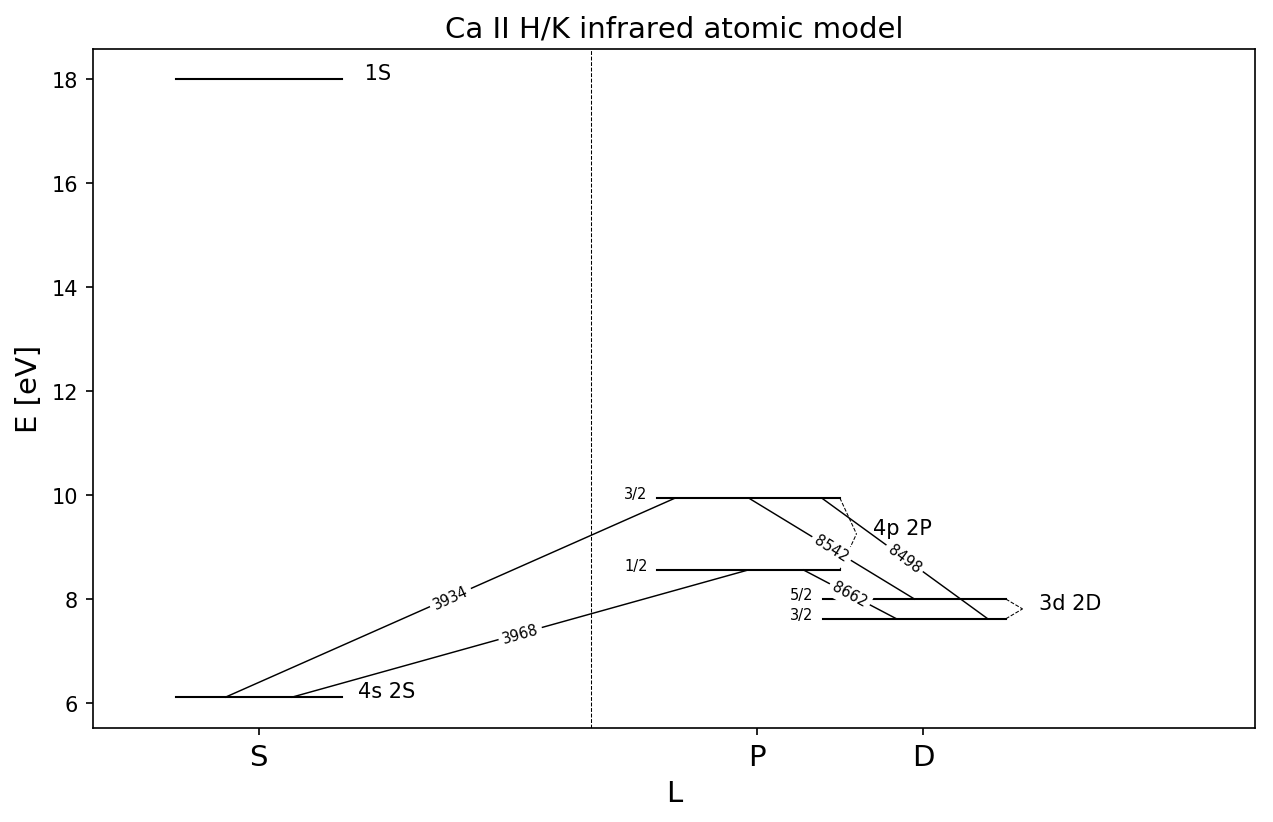

In [7]:
gro = Grotrian.Grotrian(_atom=atom, _conf_prefix="1s2.2s2.2p6.3s2.3p6.")
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

line_plot = (
        (0, 3, "3968", 0.7, 0.5),
        (0, 4, "3934", 0.3, 0.1),
        (1, 3, "8662", 0.4, 0.8),
        (1, 4, "8498", 0.9, 0.9),
        (2, 4, "8542", 0.5, 0.5),
    )
for i, j, wl, _r1, _r2 in line_plot:
    _ctj1 = atom.Level_ctj_table[i]
    _ctj2 = atom.Level_ctj_table[j]
    gro.connect_line(_cfj1=_ctj1, _cfj2=_ctj2, _r1=_r1, _r2=_r2, _c="black", _text=wl, _tsize=7, _r=0.4)
gro.show_fig()

---

- `.readBackgroundIntensity` : 

    read background (continuum) intensity 

In [9]:
slab0d = AtmosphereCls.AtmosphereC0d(Te=1E4, Vt=5.E5, Ne=1E12, Vd=0E5)
slab0d.readBackgroundIntensity('../data/intensity/continuum/ASTM_E490+PROM7_HI_CaII.dat')

(0, 10000)

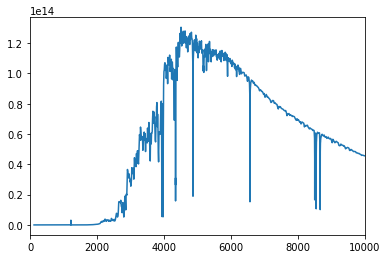

In [10]:
#slab0d.BackRad.shape
plt.plot(slab0d.BackRad[0,:]*1E8 , slab0d.BackRad[1,:])
plt.xlim(0,10000)

---

- `PhotoIonize.interpolate_PI_intensity` : 

    calculate the corresponding intensity at continuum wavelength mesh points **using interpolation**
    
    
- `PhotoIonize.interpolate_PI_alpha` : 

    calculate the corresponding photoionization cross section at continuum wavelength mesh points **using interpolation**

In [26]:
#--- 
# interpolate 
# - continuum intensity 
# - photoionization cross section 
# to compute photoionization rate
#
# assume : this intensity profile will not be affected by Doppler shift
#---
PI_I = PhotoIonize.interpolate_PI_intensity(slab0d.BackRad[:,:], 
                                            atom.Mesh.Cont)
PI_alpha = PhotoIonize.interpolate_PI_alpha(atom.PI.alpha_table, 
                                            atom.Mesh.Cont)

''

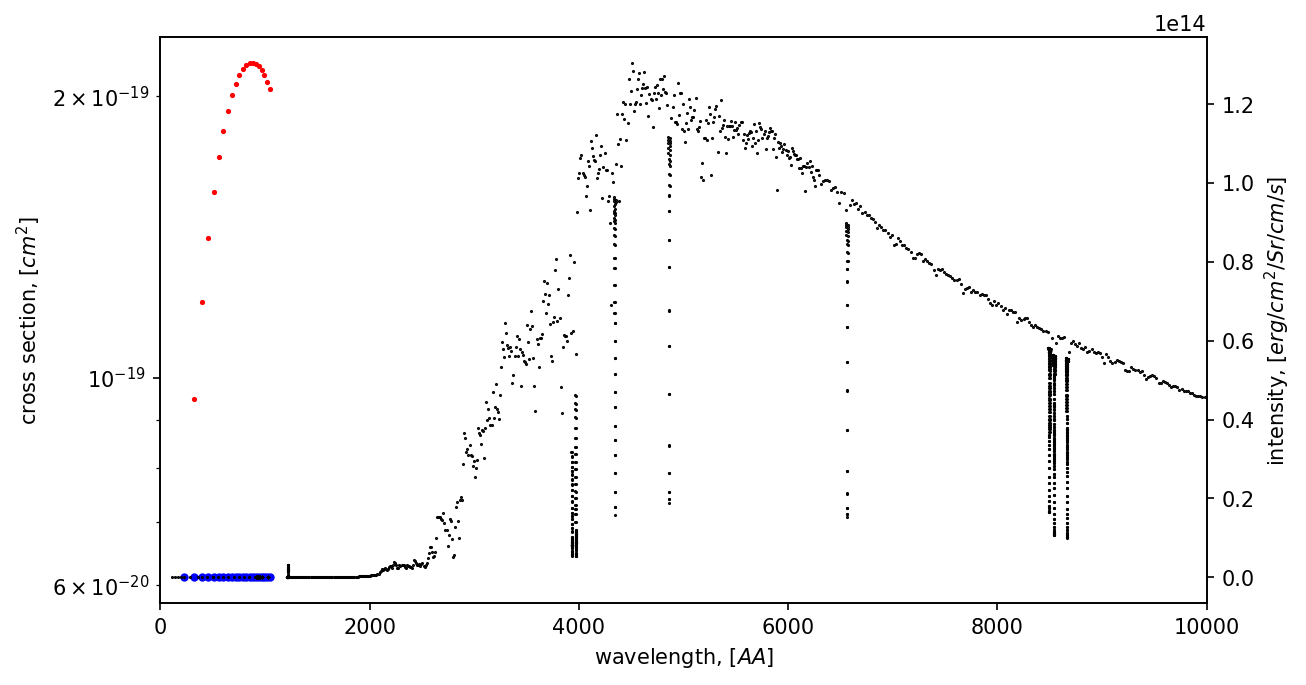

In [27]:
fig, ax1 = plt.subplots(1,1,figsize=(9,5),dpi=150)
ax2 = ax1.twinx()

for k in (0,):
    ax1.plot(atom.Mesh.Cont[k][:]*1E8,PI_alpha[k][:],
         "r.", label="photoionization cross section", markersize=3)

    ax2.plot(atom.Mesh.Cont[k][:]*1E8, PI_I[k][:], 
         "b.", label="interpolated intensity mesh", markersize=6)

ax2.plot(slab0d.BackRad[0,:]*1E8, slab0d.BackRad[1,:], "k.", 
         label="background intensity", markersize=1)
ax2.set_xlim(0,1E4)

#ax2.set_yscale("log")
ax1.set_yscale("log")

ax2.set_ylabel("intensity, [$erg/cm^2/Sr/cm/s$]")
ax1.set_xlabel("wavelength, [$AA$]")
ax1.set_ylabel("cross section, [$cm^{2}$]")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
#ax1.legend(h1+h2, l1+l2, loc='best')
;

---

In [28]:
#--- 
# physical parameters
#---
_atom = atom
_Te = slab0d.data.Te
_Te = 8000
_Ne = slab0d.data.Ne
_Ne = 1E12
_Vt = slab0d.data.Vt
_Vt = 5E5
_Vd = slab0d.data.Vd
_Vd = 100E5 # 100 [km/s]

- `LTELib.get_LTE_ratio` :
    
    compute the LTE level population base on **boltzmann distribution** and **saha's equation** (total population = 1)

In [29]:
#--- 
# compute LTE population ratio for each CE transition
#---

_n_LTE = LTELib.get_LTE_ratio(_erg=_atom.Level.erg[:], _g=_atom.Level.g[:],
                              _stage=_atom.Level.stage[:], _Te=_Te, _Ne=_Ne)

#--- 
# we are going to use LTE population ratio to convert C_{ij} to C_{ji},
# so we need the the LTE population of the lower/upper level of each transition
#---
_nTran = _atom.nTran
_nLine = _atom.nLine
_nCont = _atom.nCont

_ni_LTE = np.empty(_nTran, dtype=np.double)
_nj_LTE = np.empty(_nTran, dtype=np.double)

for k in range(_nLine):
    _ni_LTE[k] = _n_LTE[_atom.Line.idxI[k]]
    _nj_LTE[k] = _n_LTE[_atom.Line.idxJ[k]]
for k in range(_nCont):
    _ni_LTE[k+_nLine] = _n_LTE[_atom.Cont.idxI[k]]
    _nj_LTE[k+_nLine] = _n_LTE[_atom.Cont.idxJ[k]]

- `PhotoIonize.bound_free_radiative_transition_coefficient` :

    compute the rate of 
    - photoionization
    
        $$
        R_{ik} = 4\pi \int_{\nu_0}^{\infty} \alpha_{ik}(\nu) (h\nu)^{-1} J(\nu) d\nu
        $$
    
    - stimulated radiative recombination
    
        $$
        R_{ki}^{stim} = \frac{n_i^{LTE}}{n_k^{LTE}} 4\pi \int_{\nu_0}^{\infty} \alpha_{ik}(\nu) (h\nu)^{-1} J(\nu) e^{-h\nu/kT} d\nu
        $$
    
    - spontaneous radiative recombination
    
        $$
        R_{ki}^{spon} = \frac{n_i^{LTE}}{n_k^{LTE}} 4\pi \int_{\nu_0}^{\infty} \alpha_{ik}(\nu) (h\nu)^{-1} (2h\nu^{3}/c^2) e^{-h\nu/kT} d\nu
        $$

In [30]:
#--- 
# compute bound-free radiative transition rate coefficient
#    - photoionization
#    - spontaneous radiative recombination
#    - stimulated radiative recombination
#---
_Rik = np.zeros(_nCont,dtype=np.double)
_Rki_stim = np.zeros(_nCont,dtype=np.double)
_Rki_spon = np.zeros(_nCont,dtype=np.double)

for k in range(_atom.nCont):
    #_line_index = _atom.PI_coe.lineIndex[k]
    _res = PhotoIonize.bound_free_radiative_transition_coefficient(
                        wave = _atom.Mesh.Cont[k][::-1],
                        J = PI_I[k][::-1] * 0.5,
                        alpha = PI_alpha[k][::-1],
                        Te = _Te,
                        ni_lte = _ni_LTE[k+_nLine],
                        nk_lte = _nj_LTE[k+_nLine])
    _Rik[k] = _res[0]
    _Rki_stim[k] = _res[1]
    _Rki_spon[k] = _res[2]

- `BasicP.get_Level_gamma` :

    compute the reciprocal of the mean lifetime of levels (only spontaneous transitions are considered)
    
    $$
    \gamma_{j} = \sum_{i<j} A_{ji}
    $$
    
- `BasicP.get_Line_Gamma` :

    compute the reciprocal of the mean lifetime of transitions
    
    $$
    \Gamma_{i,j} = \gamma_{i} + \gamma_{j}
    $$
    
- `BasicP.get_damping_a` :

    compute the natural damping constant (dimemsionless)
    
    $$
    a \equiv \frac{\Gamma_{i,j}}{4 \pi \Delta\nu^{D}_{i,j}}
    $$
    
    where $\Delta\nu^{D}_{i,j}$ is the Doppler width in frequency unit for line transition between level $i$ and level $j$
    
    
- `BasicP.get_Doppler_width` :

    compute the Doppler width $\Delta p_{D}$, $\Delta p_{D}$ can be in wavelength or frequency unit, base on the central wavelength or frequency you passed into the function
    
    $$
    \Delta p_{D} = \frac{p_{0}}{c} (\frac{2kT}{m} + V_{turbulent}^2)^{1/2}
    $$
    
    
- `Profile.Voigt` :

    compute the Voigt profile at specific wavelength mesh (normalized to Doppler width in wavelength/frequency unit) using polynoial fitting formula
    

- `LTELib.EinsteinA_to_EinsteinBs_cm` :

    compute Einstein $B_{ij}$ and $B_{ji}$ base on Einstein's relation
    
    $$
    B_{ji} = A_{ji} / (2 h c^{2} \lambda^{5} )
    $$
    
    $$
    B_{ij} = B_{ji} \frac{g_{j}}{g_{i}}
    $$


finally compute the rate $[s^{-1}]$ of

- radiative excitation

    $$
    B_{ij} \bar{J_{\lambda_{0}}^{\varphi}} = \int_{0}^{\infty} J_{\lambda} \varphi(\lambda-\lambda_{0}) d\lambda
    $$
    
    where `\varphi(\lambda-\lambda_{0})` is the absorption profile (Voigt profile) with
    
    $$
    \int_{0}^{\infty} \varphi(\lambda-\lambda_{0}) d\lambda \equiv 1
    $$

- stimulated de-excitation

    $$
    B_{ji} \bar{J_{\lambda_{0}}^{\chi}} = \int_{0}^{\infty} J_{\lambda} \chi(\lambda-\lambda_{0}) d\lambda
    $$
    
    where $\chi(\lambda-\lambda_{0})$ is the emission profile, and with the situation of **complete distribution** we have
    
    $$
    \chi(\lambda-\lambda_{0}) = \varphi(\lambda-\lambda_{0})
    $$

In [31]:
#--- 
# compute bound-bound radiative transition rate coefficient
#    - spontaneous radiative de-excitation (Aji)
#    - radiative excitation                (Bij * J)
#    - stimulated radiative de-excitation  (Bji * J)
#---
# compute Level gamma
BasicP.get_Level_gamma(Aji=_atom.Line.AJI[:],idxJ=_atom.Line.idxJ[:],
                       gamma=_atom.Level.gamma[:])
# compute Line Gamma
BasicP.get_Line_Gamma(idxI=_atom.Line.idxI[:], idxJ=_atom.Line.idxJ[:],
                    gamma=_atom.Level.gamma[:], Gamma=_atom.Line.Gamma[:])
# compute 
#   - Doppler width [cm] 
#   - damping constant a [-]
#   - wavelength mesh [cm] (Doppler shifted)
#   - absorption profile [cm^{-1}]
# for radiative line transitions
_dopWidth_cm = np.zeros(_atom.nRadiativeLine, np.double)
_a = np.zeros(_atom.nRadiativeLine, np.double)
_Bij_Jbar = np.zeros(_atom.nLine, np.double)
_Bji_Jbar = np.zeros(_atom.nLine, np.double)

#subLine = _atom.Line[_atom.I_Rad.lineIndex]
for k in range(_atom.nRadiativeLine):
    _line_index = _atom.I_Rad.lineIndex[k]
    _w0 = _atom.Line.w0[ _line_index ]
    _f0 = _atom.Line.f0[ _line_index ]
    _dopWidth_cm[k] = BasicP.get_Doppler_width(p0=_w0, Te=_Te, Vt=_Vt, am=_atom.Mass)
    _a[k] = BasicP.get_damping_a(_Gamma=_atom.Line.Gamma[_line_index], 
                                 _dopWidth_hz=_dopWidth_cm[k]*_f0/_w0 )
    
    # shift wavelength mesh
    _wave_mesh = _atom.Mesh.RadLine[k][:]
    _wave_mesh_shifted = _wave_mesh - (_w0*_Vd/Cst.c_)/_dopWidth_cm[k]
    _wave_mesh_cm = _wave_mesh_shifted[:] * _dopWidth_cm[k]
    _absorb_mesh_cm = Profile.Voigt(_a[k], _wave_mesh[:]) / _dopWidth_cm[k]
    #print(Integrate.Trapze(_absorb_mesh_cm[:], _wave_mesh_cm))
    
    _radLine = _atom.I_Rad.I_cm[k]
    _fill_value = (_radLine[1,0],_radLine[1,-1])
    _f = interp1d(x=_radLine[0,:], y=_radLine[1,:],
                  bounds_error=False, fill_value=_fill_value)
    _I_cm = _f(_wave_mesh_cm)
    
    _gi = _atom.Level.g[ _atom.Line.idxI[_line_index] ]
    _gj = _atom.Level.g[ _atom.Line.idxJ[_line_index] ]
    _Aji = _atom.Line.AJI[_line_index]
    _Bji, _Bij = LTELib.EinsteinA_to_EinsteinBs_cm(_Aji, _w0, _gi, _gj)
    
    _integrand = 0.5 * _I_cm[:] * _absorb_mesh_cm
    _Jbar = Integrate.Trapze(integrand=_integrand, x=_wave_mesh_cm)
    
    _Bji_Jbar[_line_index] = _Bji * _Jbar
    _Bij_Jbar[_line_index] = _Bij * _Jbar
    

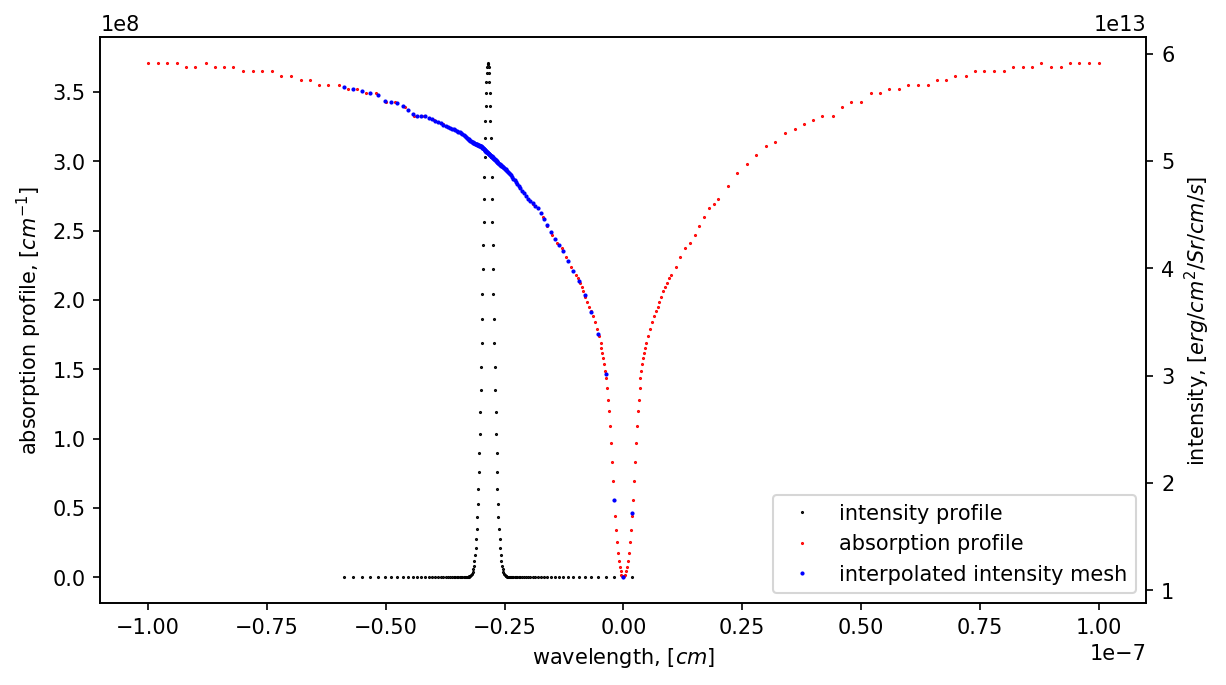

In [32]:
fig, ax1 = plt.subplots(1,1,figsize=(9,5),dpi=150)
ax1.plot(_wave_mesh_cm, _absorb_mesh_cm, "k.", 
         label="intensity profile", markersize=1)


ax2 = ax1.twinx()
ax2.plot(_radLine[0,:],_radLine[1,:],
         "r.", label="absorption profile", markersize=1)
ax2.plot(_wave_mesh_cm, _I_cm, "b.", 
         label="interpolated intensity mesh", markersize=2)

ax2.set_ylabel("intensity, [$erg/cm^2/Sr/cm/s$]")
ax1.set_xlabel("wavelength, [$cm$]")
ax1.set_ylabel("absorption profile, [$cm^{-1}$]")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right');

- `Collision.interpolate_CE_fac` : 

    calculate the effective collisional strength for collisional excitation under a specific temperature using interpolation
    
    
- `Collision.interpolate_CI_fac` : 

    calculate the effective collisional strength (?) for collisional ionization under a specific temperature using interpolation
    
   
   
- `Collision.get_CE_rate_coe` :

    calculate collisional excitation rate coefficient
    
    $$
    C_{ij} = \frac{8.63e-6 \times (\Omega_{ij} f_1 / f_2) }{g_{i} T_{e}^{1/2}}  \exp{\frac{-dE_{ji}}{kT_{e}} } \quad [s^{-1}cm^{3}]
    $$
    
    
- `Collision.get_CI_rate_coe` :

    calculate collisional ionization rate coefficient
    
    $$
    C_{ik} = (\Omega_{ik} / f_2) * \exp{\frac{-dE}{kT_{e}}} * \sqrt{T_{e}}, \quad [s^{-1}cm^{3}]
    $$
    
    
- `Collision.Cij_to_Cji` :

    $$
    n_j^{LTE} C_{ji} = n_i^{LTE} C_{ij}
    $$

In [70]:
#--- 
# compute collision 
#    - excitation/de-excitation 
#    - ionization/recombination
# rate coefficient
#---
_CE_fac = Collision.interpolate_CE_fac(
            _table=_atom.CE.Omega_table[:,:], _Te=_Te, 
            _Te_table=_atom.CE.Te_table[:], 
            _f1=_atom.CE.Coe.f1[:], _f2=_atom.CE.Coe.f2[:])
    
_CEij = Collision.get_CE_rate_coe(_CE_fac=_CE_fac, _Te=_Te, 
                                  _gi=_atom.CE.Coe.gi[:],
                                  _dEij=_atom.CE.Coe.dEij[:])

_CI_fac = Collision.interpolate_CI_fac(_table=_atom.CI.Omega_table[:,:], 
                                       _Te=_Te, 
                                       _Te_table=_atom.CI.Te_table[:], 
                                       _f2=_atom.CI.Coe.f2[:])

_CIik = Collision.get_CI_rate_coe(_CI_fac=_CI_fac[:], _Te=_Te, 
                                  _dEik=_atom.CI.Coe.dEij[:])

#_Cij = _CEij[:] + _CIik[:]
_Cij = np.append( _CEij[:], _CIik[:] )
_Cji = Collision.Cij_to_Cji(_Cij=_Cij,  _ni_LTE=_ni_LTE, _nj_LTE=_nj_LTE)

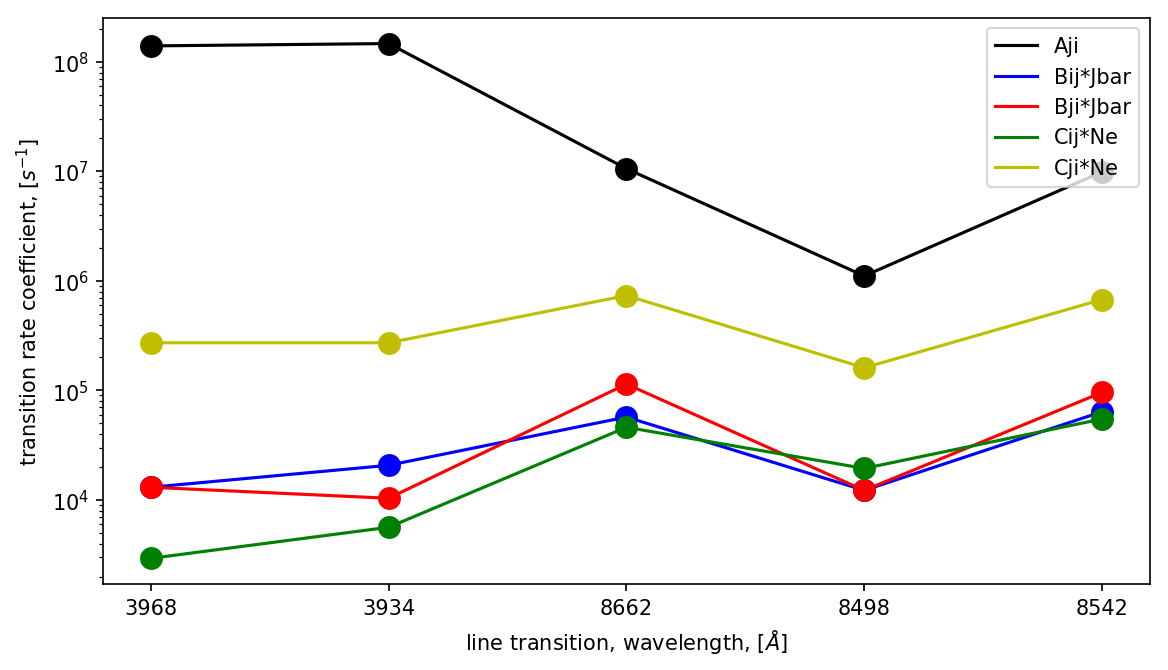

In [66]:
fig, ax = plt.subplots(1,1,figsize=(9,5),dpi=150)
mask = []
for k in range(_atom.nRadiativeLine):
    mask.append( _atom.Mesh.Coe.lineIndex[k] )

ax.plot(_atom.Line.AJI[mask], "k-", label="Aji")
ax.plot(_Bij_Jbar[mask], "b-", label="Bij*Jbar")
ax.plot(_Bji_Jbar[mask], "r-", label="Bji*Jbar")
ax.plot(_Cij[mask]*_Ne, "g-", label="Cij*Ne")
ax.plot(_Cji[mask]*_Ne, "y-", label="Cji*Ne")

ax.plot(_atom.Line.AJI[mask], "ko", markersize=10)
ax.plot(_Bij_Jbar[mask], "bo", markersize=10)
ax.plot(_Bji_Jbar[mask], "ro", markersize=10)
ax.plot(_Cij[mask]*_Ne, "go", markersize=10)
ax.plot(_Cji[mask]*_Ne, "yo", markersize=10)

ax.set_ylabel("transition rate coefficient, [$s^{-1}$]")
ax.set_xlabel("line transition, wavelength, [$\AA$]")

ax.set_xticks(np.arange(_atom.nRadiativeLine))
ax.set_xticklabels([f"{_w0_AA:.0f}" for _w0_AA in _atom.Line.w0_AA[mask]])
ax.set_yscale("log")
ax.legend(loc="best")
plt.show()

- `SEsolver.setMatrixC` :

    construct the collisional transition matrix $n_{e}C_{ij}$
  
  
- `SEsolver.setMatrixR` :

    construct the radiative transition matrix $R_{ij}$
    

- `SEsolver.solveSE` :

    given the collisional transition matrix $n_{e}C_{ij}$ and the radiative transition matrix $R_{ij}$, solve the statistical equilibrium equations
    
    $$
    \sum_{j \neq i} n_j (R_{ji}+n_{e}C_{ji}) - n_i \sum_{j \neq i}(R_{ij}+n_{e}C_{ij}) = 0
    $$
    
    with 
    
    $$
    \sum_{i}n_{i} = 1
    $$

In [71]:
#--- 
# set MatrixC (collisional)
#---
_idxI = np.append(_atom.Line.idxI[:], _atom.Cont.idxI[:])
_idxJ = np.append(_atom.Line.idxJ[:], _atom.Cont.idxJ[:])

_nLevel = _atom.nLevel
_Cmat = np.zeros((_nLevel, _nLevel), dtype=np.double)
SEsolver.setMatrixC(_Cmat=_Cmat[:,:], 
                    _Cji=_Cji[:], _Cij=_Cij[:],
                    _idxI=_idxI, _idxJ=_idxJ, _Ne=_Ne)

#--- 
# set MatrixR (radiative)
#---
_Rmat     = np.zeros((_nLevel, _nLevel), dtype=np.double)

_Rji_spon = np.append(atom.Line.AJI[:], _Rki_spon[:])
_Rji_stim = np.append(_Bji_Jbar[:], _Rki_stim[:])
_Rij = np.append(_Bij_Jbar[:], _Rik[:])

SEsolver.setMatrixR(_Rmat=_Rmat[:,:], 
                    _Rji_spon=_Rji_spon,_Rji_stim=_Rji_stim, _Rij=_Rij, 
                    _idxI=_idxI, _idxJ=_idxJ)
#--- 
# solve statistical equilibrium equations
#---
_n_SE = SEsolver.solveSE(_Rmat=_Rmat[:,:], _Cmat=_Cmat[:,:])

In [72]:
_n_LTE

array([1.70001032e-02, 2.91756147e-03, 4.32880060e-03, 1.82924805e-04,
       3.51466436e-04, 9.75219143e-01])

In [73]:
_n_SE

array([2.15999620e-02, 1.27562431e-03, 1.90729637e-03, 3.24836283e-06,
       5.25577469e-06, 9.75208613e-01])

---

# saha's equation with partition function

- `LTELib.Ufunc` : 

    given string of the ion and electron temperature, calculate the **ion partition function** using polynomial fitting formula
    
    **Warning** : availble for low temperature only ($<10000 K$)

$$
\frac{N_{j}}{N_{j+1}} = C_{I} n_{e} (\frac{U_{j}}{U_{j+1}}) \exp(\frac{\chi_{j,j+1}}{kT}) T^{-3/2}
$$

where

- $j$ is an index of ionization stage


- $C_{I} = \frac{1}{2}(\frac{h^{2}}{2 \pi m_{3} k})^{3/2} = 2.07 \times 10^{-16}$


- $U_{j}$ is the partition function for an ion at ionization stage $j$


- $\chi_{j,j+1}$ is the ionization energy for an ion from ionization stage $j$ to ionization stage $j+1$

In [22]:
_Te = 5E4   #[K]
_Ne = 1E13  #[cm^{-3}]
_chi = 11.8717*Cst.eV2erg_ #(_atom.Level.erg[-1] - _atom.Level.erg[0])

_C_I = 0.5 * (Cst.h_*Cst.h_/(2*Cst.pi_*Cst.me_*Cst.k_))**1.5

_U = {'Ca_II':0, 'Ca_III':0}
for _ele in _U.keys():
    _U[_ele] = LTELib.Ufunc(_ele, _Te)
_U

{'Ca_II': 28.158016178516515, 'Ca_III': 1.0}

In [23]:
_ratio = _C_I * _Ne * (_U["Ca_II"]/_U["Ca_III"]) * \
            np.exp(_chi/Cst.k_/_Te) * _Te**(-1.5)
print("N_{j] / N_{j+1} = ", _ratio)

N_{j] / N_{j+1} =  8.201098430459023e-08
